# NN (L) Global Sustainable Equity time series forecasting using Prophet

## Start timing the analysis

In [1]:
import timeit
start_time = timeit.default_timer()

## Import all the necessary libraries

In [2]:
# ## Import all the necessary libraries
import time
import os
import datetime as dt
import pandas as pd
import io
import matplotlib.pyplot as plt

from fbprophet import Prophet
import itertools
import numpy as np
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
from dask.distributed import Client # import Dask for parallelising cross validation

## Import, clean and visualise the historical data

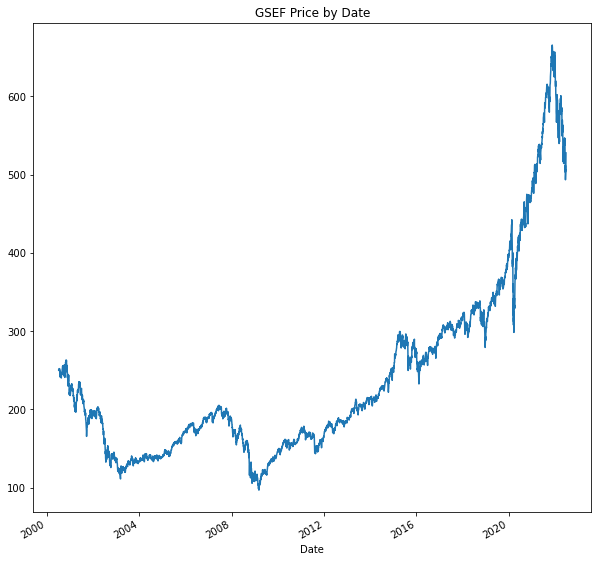

In [3]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_column',None)
tomorrow = (dt.date.today() + dt.timedelta(days=1)).isoformat() #get tomorrow in iso format as needed'''
url = pd.read_html("https://markets.ft.com/data/funds/tearsheet/historical?s=LU0119216553:EUR", header=0)
table = url[0]
gsef_latest = table[['Date', 'Close']]
gsef_latest_selected= gsef_latest.copy()

gsef_latest_selected['Date'] = gsef_latest_selected.loc[:,'Date'].str[-12:]
gsef_latest_selected['Date'] = pd.to_datetime(gsef_latest_selected['Date'], dayfirst=True)

gsef_historical= pd.read_csv('gsef_output/historical_gsef.csv', parse_dates=['Date'], dayfirst=True)

gsef = pd.concat([gsef_latest_selected, gsef_historical], ignore_index=True).sort_values(by="Date")

gsef = gsef.reset_index(drop=True)

gsef['pct_change']= (gsef["Close"].pct_change()*100).round(2)

gsef = gsef.drop_duplicates('Date')

gsef.to_csv('gsef_output/historical_gsef.csv', index=False)

gsef.plot(x= 'Date', y='Close', figsize=(10,10), title= 'GSEF Price by Date', legend=False)

historical_chart= 'gsef_output/gsef_historical.png'

# Check if the historical data's chart exists and save its latest version
if os.path.exists(historical_chart):
  os.remove(historical_chart)
else:
  print("The historical chart didn't exist and it has been created.")

plt.savefig('gsef_output/gsef_historical.png')

plt.show()

In [4]:
# Brief Description of our dataset
gsef.describe()

Close   pct_change
count  5547.000000  5546.000000
mean    239.345560     0.019492
std     117.814208     1.084683
min      96.810000    -9.930000
25%     157.460000    -0.470000
50%     195.630000     0.070000
75%     292.125000     0.550000
max     665.450000     9.540000

In [5]:
gsef.info() # Check whether the date is as object type or date type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5547 entries, 0 to 5560
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5547 non-null   datetime64[ns]
 1   Close       5547 non-null   float64       
 2   pct_change  5546 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 173.3 KB


In [6]:
gsef.head()

Date   Close  pct_change
0 2000-07-07  250.00         NaN
1 2000-07-10  250.00        0.00
2 2000-07-11  250.00        0.00
3 2000-07-12  249.61       -0.16
4 2000-07-13  249.80        0.08

In [7]:
# Drop the columns
gsef = gsef.drop('pct_change', axis=1)
gsef.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

gsef.head()

ds       y
0 2000-07-07  250.00
1 2000-07-10  250.00
2 2000-07-11  250.00
3 2000-07-12  249.61
4 2000-07-13  249.80

## Hyperparameter tuning

In [ ]:
client = Client()  # connect to the cluster

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'daily_seasonality': [False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(gsef)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="dask")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Making 509 forecasts with cutoffs between 2001-07-14 00:00:00 and 2022-05-25 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:62952' processes=4 threads=8, memory=15.39 GiB>


In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

In [10]:
changepoint_prior_scale= best_params['changepoint_prior_scale']
seasonality_prior_scale= best_params['seasonality_prior_scale']

## Initiating and training the Prophet algorithm

Steps for using Prophet:
- Make sure you replace closing price for y and date for ds.
- Fit that dataframe to Prophet in order to detect future patterns.
- Predict the upper and lower prices of the closing price.

In [11]:
m = Prophet(daily_seasonality=False, changepoint_prior_scale= changepoint_prior_scale, seasonality_prior_scale= seasonality_prior_scale)

m.fit(gsef)

In [12]:
# Create Future dates
future_prices = m.make_future_dataframe(periods=365)

# Predict Prices
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
5903 2023-06-13  675.815727  635.427611  717.864111
5904 2023-06-14  676.187005  634.484015  717.629937
5905 2023-06-15  676.320037  633.793865  721.323152
5906 2023-06-16  676.510530  634.541930  719.044734
5907 2023-06-17  676.011112  633.801592  717.279254

You can plot the forecast by calling the Prophet.plot method and passing in your forecast dataframe.

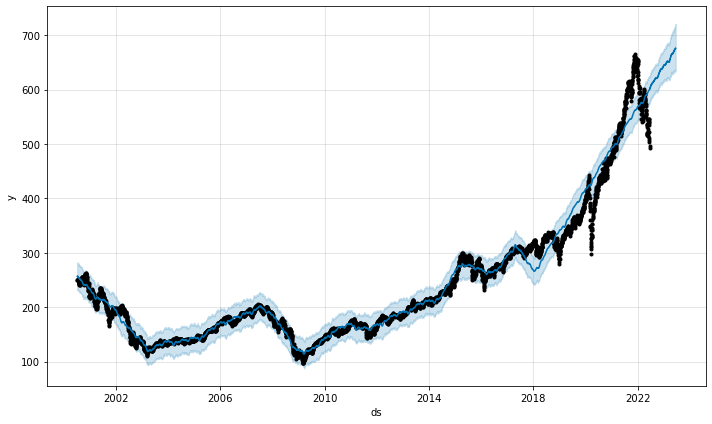

In [13]:
fig1 = m.plot(forecast)

If you want to see the forecast components, you can use the Prophet.plot_components method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

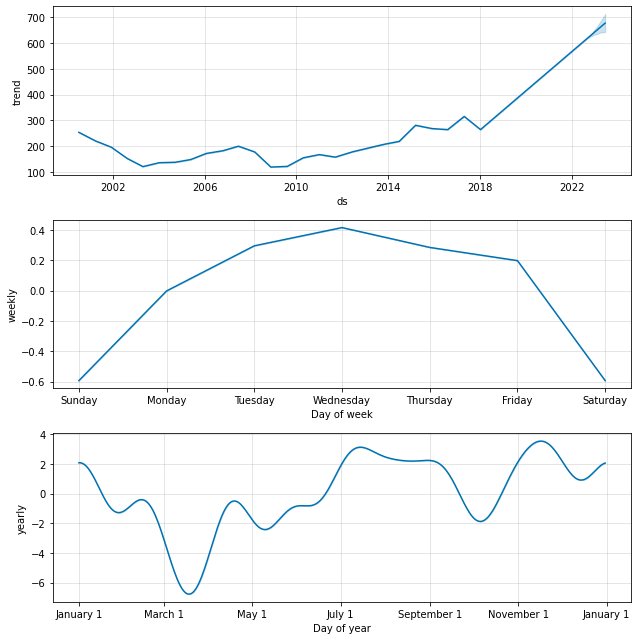

In [14]:
fig2 = m.plot_components(forecast)

An interactive figure of the forecast and components can be created with plotly. You will need to install plotly 4.0 or above separately, as it will not by default be installed with prophet. You will also need to install the notebook and ipywidgets packages.

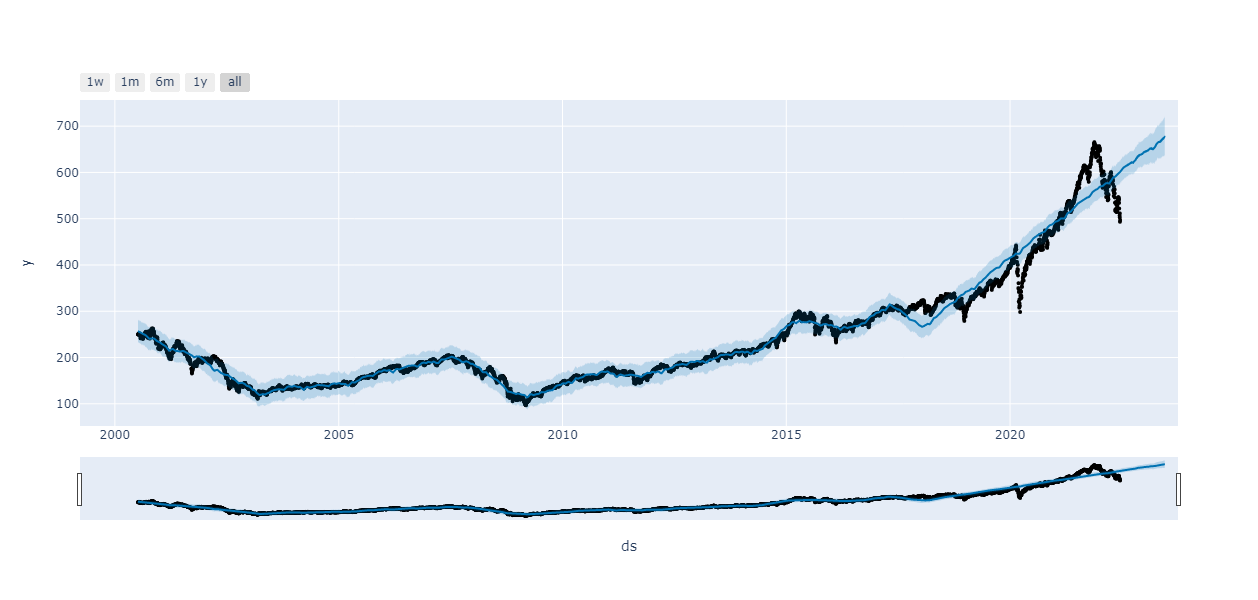

In [15]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

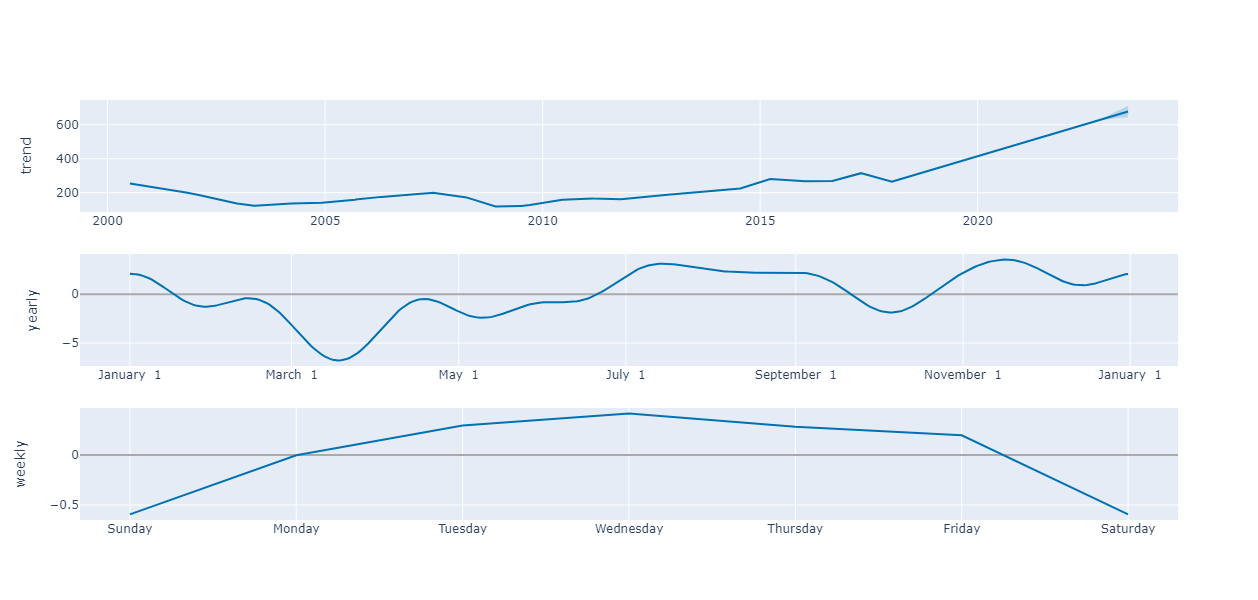

In [16]:
plot_components_plotly(m, forecast)

## Parallelized Cross validation

In [17]:
df_cv = cross_validation(m, horizon='30 days', parallel="dask")

INFO:prophet:Making 39 forecasts with cutoffs between 2002-09-25 00:00:00 and 2021-06-17 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:53667' processes=4 threads=8, memory=15.39 GiB>


In [18]:
df_cv.head()

ds        yhat  yhat_lower  yhat_upper       y     cutoff
0 2002-09-26  131.819462  127.300325  135.933084  134.50 2002-09-25
1 2002-09-27  130.837689  126.540477  135.213800  133.05 2002-09-25
2 2002-09-30  130.180592  125.729490  134.517911  128.56 2002-09-25
3 2002-10-01  129.915892  125.234753  134.534828  131.80 2002-09-25
4 2002-10-02  129.265406  124.942614  133.930377  132.37 2002-09-25

In [19]:
df_p = performance_metrics(df_cv)
df_p.head()

horizon         mse       rmse        mae      mape     mdape     smape  \
0 37 days  645.900418  25.414571  16.778532  0.070846  0.046323  0.072818   
1 38 days  650.634979  25.507547  16.877577  0.071345  0.046323  0.073283   
2 39 days  663.836987  25.765034  16.981032  0.071532  0.046164  0.073475   
3 40 days  674.970742  25.980199  17.105825  0.072075  0.046323  0.074074   
4 41 days  687.404093  26.218392  17.298565  0.072998  0.046642  0.075055   

   coverage  
0  0.447218  
1  0.445386  
2  0.446396  
3  0.444739  
4  0.441687

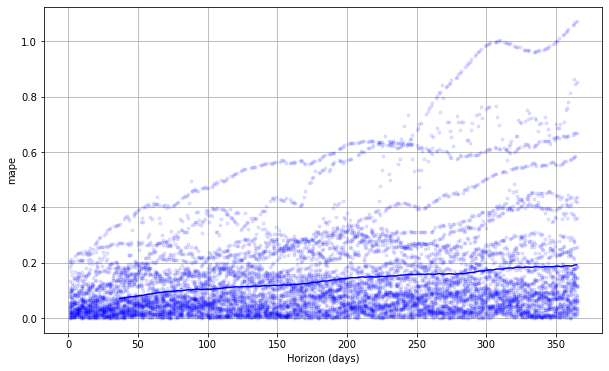

In [20]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

### Next:

1) Can more hyperparameter tuning can be done to significantly improve accuracy?
2) Check if Prophet's output has been suppressed 
3) If necessary, re-order the analysis in the notebook and automate the analysis wherever possible
4) Remove any unnecessary or low value steps from the analysis 
5) Document the notebook 
6) Create a .py script of the notebook 
7) Publish the project publicly on Github

## Calculate the analysis' and forecast's timing

In [22]:
# Calculate and print the time elapsed to run ETL process and the date and time of the latest run
time_elapsed = timeit.default_timer() - start_time

time_elapsed_minutes = int((time_elapsed % 3600) // 60)

time_elapsed_seconds = int(time_elapsed % 60)

now = dt.datetime.now()

print("\n Success! Your GSEF forecast using Prophet has been updated in {} minutes and {} seconds on {}".format(time_elapsed_minutes, time_elapsed_seconds, now.strftime("%Y-%m-%d %H:%M:%S")))


 Success! Your GSEF forecast using Prophet has been updated in 41 minutes and 56 seconds on 2022-06-21 13:40:29
